## 1. Introduction

This post provides an introduction to fine-tunning techniques that are taught in the Machine Learning subject of the intensive course in computing of the UAB's Bachelor's Degree in Computer Engineering. In it, we will learn how to fine-tune a **Convolutional Neural Network (CNN)** for a vision-related classification task. The code for this blog post can be found [here](https://github.com/dvd42/fine-tunning-with-pytorch).

## 2. Fine-Tunning

In Deep Learning fine-tunning refers to the practice of taking the parameters of a **pre-trained** neural network (usually a **CNN**) and change them slightly. Training the network to generalize on a different dataset from that which it was trained on.

### 2.1 Why do we use fine-tunning?

1. Convolutional Networks usually have a large number of parameters, often in the range of **millions**. Training one of these CNNs with a dataset that is significantly smaller than the number of parameters it has, will prevent it from generalizing, making it **overfit** the data.

2. Training a Network with millions of parameters from scratch takes a large amount of time.  

Fine-tunning bypass **both** of these problems by taking an already trained network, modifying it slightly and **re-train it on new data**. Avoiding overfitting and making the training significantly faster.








### 2.2 How to fine-tune?


The first thing you have to do is change only the last fully-connected layer of the network, replacing with your own layer with your own, having as many output units as your task requires. For example: A network trained with **Imagenet** will have **1000 neurons** on the last layer, since Imagenet has 1000 classes. If our dataset has only **10 classes** we just replace the last layer with one that has **10 neurons**.

Once this is done Fine-tunning can be performed in mainly in 3 different ways:

1. **Freeze the entire network** and train only the **newly added layer** with a normal learning rate. 


2. **Freeze the first layers** of the network **(no backprop)** and train the rest of the network with a **smaller learning rate**. Since the first convolutional layers always **focus on edges and corners** it is very likely that we don't have to change their weights because no matter what your image has in it, it will always have corners and edges. The **newyly added layer** should be trained with a normal learning rate.  


3. Re-train the **entire network** with high learning rate. The previous approaches cna work when the domain of the new task is **similar** to the one with which the network was pre-trained. But when the domain of the new task **differs** a lot from the original one, the network must **re-learn a lot**, and so **more agressive** parameter updates are required.



![weights](fine-tunning_images/weights.png)


## 3. Dependencies

For this task we will use the following libraries: 
   
   * Numpy: For matrix and vector operations
   * Pytorch: Train and validate our neural network using parallel GPU computation
   * Matplotlib: To visualize data

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import models, datasets

import matplotlib.pyplot as plt

## 4. Dataset

The Dataset that we will use for this blog is the one used at the ISIC lesion diagnosis challenge. The lesion images come from the HAM10000 Dataset, and were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. 

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.  
The Dataset consists of 10015 images belonging to one of 6 of the following classes.

![data](fine-tunning_images/data.png)

## 5. Preparing Data

For this task we will use a **Resnet18** network architecture trained on **Imagenet**.  

![resnet18](fine-tunning_images/resnet18.png)

In [2]:
# First thing we have to do is download the pre-trained model using PyTorch
model = models.resnet18(pretrained=True)

### 5.1 Data augmentation

For this dataset we can use some data augmentation techniques. A very common practice is to Randomly flip an image horizontally. Since no information is lost by performing this operation, we can effectively augment the amount of images in our dataset.  
On top of that you can also crop a random section of the image and feed that to the network, this is also a good technique to effectively augment the amount of images in the dataset while also helping the network to generalize better since it adds more variance to the data.

### 5.2 Data Normalization

The network must be used with 224x244 images. Also the images with which the network was trained were normalized using the Imagenet mean and standard deviation. We will adapt our data keeping these 2 things in mind.


In [3]:
# Data augmentation and normalization
train_trans = T.Compose([T.RandomResizedCrop(224), T.RandomHorizontalFlip(), T.ToTensor(),
                                  T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_trans = T.Compose([T.Resize(224),T.CenterCrop(224), T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [4]:
# Create training and validation datasets
train_set = datasets.ImageFolder("/home/diego/DATASETS/ISIC_Challenge/train", train_trans)
val_set = datasets.ImageFolder("/home/diego/DATASETS/ISIC_Challenge/val", val_trans)

In [5]:
# Establish hyper-parameters
batch_size = 256
lr = 0.05
n_gpus = 2
momentum = 0.9
epochs = 50

In [6]:
# Create our dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

Our data is now ready to be fed into the model.

## 6. Modify the model

As mentioned above the network must be modified slightly before the fine-tunning process. Since the **domain** of the **data** is **quite different** from the one in which the network was trained we will use approach **3**.

In [7]:
# Modify last layer
in_features = model.fc.in_features 
model.fc = nn.Linear(in_features, 7) # we have 7 classes

In [8]:
model = model.cuda() # move model to GPU

### 6.1 Multiple GPUs

Some models are too big for even the most powerful GPUs in the market, that's why it is necessary to train some models on more than one GPU in parallel.

In [9]:
# Train the model on all gpus
model = nn.DataParallel(model, list(range(n_gpus))) 

## 7. Training and Validation
Now we can start the training and validation of our model.

In [10]:
# Create loss function
criterion = nn.CrossEntropyLoss()
# Create optimizer for the network parameters
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
torch.backends.cudnn.benchmark = True # choose the optimal convolution algorithm

def train():
    
    model.train() # set model to training mode
    
    running_loss = 0
    running_corrects = 0
    total = 0

    for data, labels in train_loader:
        
        optimizer.zero_grad()  # make the gradients 0
        
        x = data.cuda()
        y = labels.cuda()
        
        output = model(x)  # forward pass
        loss = criterion(output, y)  # calculate the loss value
        preds = output.max(1)[1] # get the predictions for each sample


        loss.backward() # compute the gradients
        optimizer.step() # uptade network parameters

        # statistics
        running_loss += loss.item() * x.size(0)
        # .item() converts type from torch to python float or int
        running_corrects += torch.sum(preds == y).item()
        total += float(y.size(0))

    epoch_loss = running_loss / total  # mean epoch loss
    epoch_acc = running_corrects / total  # mean epoch accuracy

    return epoch_loss, epoch_acc


def val():

    model.eval()  # set model to validation mode

    running_loss = 0
    running_corrects = 0
    total = 0
    
    # We are not backpropagating through the validation set, so we can save time  and memory 
    # by not computing the gradients
    with torch.no_grad():
        
        for data, labels in val_loader:
            
            x = data.cuda()
            y = labels.cuda()
        
            output = model(x)  # forward pass 
            
            # Calculate the loss value (we do not to apply softmax to our output because Pytorch's 
            # implementation of the cross entropy loss does it for us)
            loss = criterion(output, y) 
            preds = output.max(1)[1] # get the predictions for each sample
            
            # Statistics
            running_loss += loss.item() * x.size(0)
            # .item() converts type from torch to python float or int
            running_corrects += torch.sum(preds==y).item()
            total += float(y.size(0))
    
    epoch_loss = running_loss / total # mean epoch loss
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc

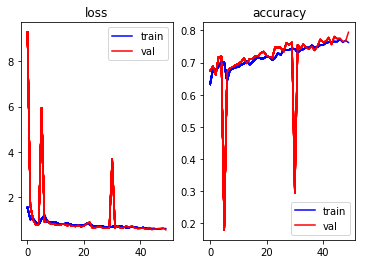

In [11]:
# Remove this line out of jupyter notebooks
from IPython import display

train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Training loop
for epoch in range(epochs):
    
    loss, acc = train()
    train_loss.append(loss)
    train_accuracy.append(acc)
    
    loss, acc = val()
    val_loss.append(loss)
    val_accuracy.append(acc)
    
    plt.subplot(1,2,1)
    plt.title("loss")
    plt.plot(train_loss, 'b-')
    plt.plot(val_loss, 'r-')
    plt.legend(["train", "val"])
    plt.subplot(1,2,2)
    plt.title("accuracy")
    plt.plot(train_accuracy, 'b-')
    plt.plot(val_accuracy, 'r-')
    plt.legend(["train", "val"])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output(wait=True)

In [12]:
print(max(val_accuracy))

0.7945137157107232


## 8. Conclusions

On this blog post we learned how to use PyTorch to fine-tune a Convolutional Neural Network using multiple GPUs and data augmentation and normalization techniques.  
We obtain a $79.4\%$ accuracy score. Of course this model can be optimized much more by tinkering with the hyper-parameters a little, by using a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) and in many other ways.  
Feel free to download this [notebook](https://github.com/dvd42/fine-tunning-with-pytorch) and experiment with various configurations.